In [311]:
import os
import glob
import uproot
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
import mplhep as hep
plt.style.use(hep.style.CMS)
import yahist
from tqdm import tqdm

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

PLOTS_DIR = "/home/users/jguiang/public_html/lhe_plots/vbswh"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [202]:
def get_lhe_df(input_dir, lumi_invfb=138):
    """
    Extract kinematics, etc. from LHE files converted to ROOT files by utils/leshouche.py
    """
    dfs = []
    for root_file in tqdm(glob.glob(input_dir)):
        kW, kZ = (-999, -999)
        name = root_file.split("/")[-1].replace("_Inclusive_4f_LO.root", "")
        if name == "VBSWH":
            kW, kZ = (1, 1)
        elif name == "VBSWH_mkW":
            kW, kZ = (-1, 1)
        elif name == "VBSWH_mkZ":
            kW, kZ = (1, -1)
        elif "kW" in name:
            kZ = 1
            kW = float(name.replace("VBSWH_", "").replace("m", "-").replace("p", ".").replace("kW", ""))
        elif "kZ" in name:
            kW = 1
            kZ = float(name.replace("VBSWH_", "").replace("m", "-").replace("p", ".").replace("kZ", ""))
        else:
            raise Exception(f"unable to parse {root_file} for kW, kZ values!")

        with uproot.open(root_file) as f:
            # Extract kinematics df
            df = f["Events"].arrays(library="pd").reset_index(level=[0,1])
            # Calculate pT
            df["P_T"] = np.sqrt(df.P_X**2 + df.P_Y**2)
            # Calculate cross section scale factor
            xsec_pb = f["Processes"].arrays()[0]["XSECUP"]
            df["xsec_sf"] = (1000*xsec_pb*lumi_invfb)/len(df)
            df["kW"] = kW
            df["kZ"] = kZ

            # Require that it is VBSWH (pp -> WHqq):
            #     other processes have extra particles that come from W, H, or one of the VBS q's, 
            #     so we can reject any event that has a particle whose mother is not the first or 
            #     second particle, i.e. the incoming partons
            df = df[~np.isin(df.entry, df[df.MOTHUP1 > 1].entry.unique())]

            dfs.append(df)

    return pd.concat(dfs)
    
df = get_lhe_df("/ceph/cms/store/user/jguiang/VBSWHSignalGeneration/lhe/new_vbswh_singlepoint/*.root")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:36<00:00,  1.76s/it]


In [365]:
def get_ST_hist(kW, kZ, bins):
    # Get mask for kW, kZ point
    kWkZ = (df.kW == kW) & (df.kZ == kZ)
    # Get W, H pT
    W_pt = df[kWkZ & (df.IDUP.abs() == 24)].P_T.values
    H_pt = df[kWkZ & (df.IDUP.abs() == 25)].P_T.values
    # Get events weights
    wgts = df[kWkZ & (df.IDUP.abs() == 24)].xsec_sf.values
    
    return yahist.Hist1D(W_pt + H_pt, bins=bins, weights=wgts)

def get_M_WH_hist(kW, kZ, bins):
    # Get mask for kW, kZ point
    kWkZ = (df.kW == kW) & (df.kZ == kZ)
    # Get W 4-vector
    W_px = df[kWkZ & (df.IDUP.abs() == 24)].P_X.values
    W_py = df[kWkZ & (df.IDUP.abs() == 24)].P_Y.values
    W_pz = df[kWkZ & (df.IDUP.abs() == 24)].P_Z.values
    W_E  = df[kWkZ & (df.IDUP.abs() == 24)].E.values
    # Get H 4-vector
    H_px = df[kWkZ & (df.IDUP.abs() == 25)].P_X.values
    H_py = df[kWkZ & (df.IDUP.abs() == 25)].P_Y.values
    H_pz = df[kWkZ & (df.IDUP.abs() == 25)].P_Z.values
    H_E  = df[kWkZ & (df.IDUP.abs() == 25)].E.values
    # Calculate components of invariant mass
    WH_P2 = (W_px + H_px)**2 + (W_py + H_py)**2 + (W_pz + H_pz)**2
    WH_E2 = ( W_E + H_E )**2
    # Get event weights
    wgts = df[kWkZ & (df.IDUP.abs() == 24)].xsec_sf.values
    
    return yahist.Hist1D(np.sqrt(WH_E2 - WH_P2), bins=bins, weights=wgts)

def plot_var(var, bins):
    print(f"Plotting {var} for a selection of kW, kZ points...")
    if var == "ST":
        get_hist = lambda kW, kZ, bins: get_ST_hist(kW, kZ, bins).normalize()
    elif var == "M_WH":
        get_hist = lambda kW, kZ, bins: get_M_WH_hist(kW, kZ, bins).normalize()
    else:
        raise Exception(f"{var} not supported")
        
    # Get SM hist
    sm_hist = get_hist(1, 1, bins)
    
    # Plot other points
    kV_points = [0.5, 0.0, -0.5, -1.5]
    kV_styles = [
        {"color": "#97cae1", "errors": False, "hatch": "\\\\"}, # 0.5
        {"color": "#6ea5cd", "errors": True, "fmt": "s"}, # 0.0
        {"color": "#feda8a", "errors": True, "fmt": "o"}, # -0.5
        {"color": "#dd3c2d", "errors": True, "fmt": "^"}, # -1.5
    ]
    for V in ["W", "Z"]:
            
        # --- Set up plot with only SM and mkV points ---
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])
        
        # Plot SM
        sm_hist.plot(ax=hist_axes, color="#364b9a", label="SM", histtype="stepfilled")
        # Plot mkVs
        mkW_hist = get_hist(-1, 1, bins)
        mkW_hist.plot(
            ax=hist_axes, color="#f67e4b", hatch="/////",
            label=r"$\kappa_W = -1$, $\kappa_Z = +1$"
        )
        mkZ_hist = get_hist(1, -1, bins)
        mkZ_hist.plot(
            ax=hist_axes, color="#97cae1", hatch="\\\\",
            label=r"$\kappa_W = +1$, $\kappa_Z = -1$"
        )
        # Plot mkV/SM ratios
        (mkW_hist/sm_hist).plot(ax=ratio_axes, errors=True, color="#f67e4b", zorder=1.2, fmt=" ")
        (mkZ_hist/sm_hist).plot(ax=ratio_axes, errors=True, color="#97cae1", zorder=1.2, fmt=" ")
        
        # Format axes
        hist_axes.set_xticklabels([])
        # Add CMS label
        hep.cms.label(
            "Preliminary",
            data=False,
            loc=0,
            ax=hist_axes,
        )
        if var == "ST":
            ratio_axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]");
        elif var == "M_WH":
            ratio_axes.set_xlabel(r"$M_{WH}$ [GeV]");

        ratio_axes.set_ylabel(r"$(\kappa_V = -1)/SM$", size=18, horizontalalignment="center")
        ratio_axes.set_yscale("log");
        
        outfile = f"{PLOTS_DIR}/lhe_{var}_mkW_mkZ.pdf"
        plt.savefig(outfile)
        plt.savefig(outfile.replace(".pdf", ".png"))
        plt.close()
        print(f"Wrote {outfile}")
        
        # --- Set up plot with more kW, kZ points ---
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])
        
        if V == "W":
            kWkZ_points = zip(kV_points, [1.0 for _ in kV_points])
            mkV_hist = get_hist(-1, 1, bins)
        elif V == "Z":
            kWkZ_points = zip([1.0 for _ in kV_points], kV_points)
            mkV_hist = get_hist(1, -1, bins)
        
        # Plot SM
        sm_hist.plot(ax=hist_axes, color="#364b9a", label="SM", histtype="stepfilled")
        # Plot kV = -1
        mkV_hist.plot(
            ax=hist_axes, color="#f67e4b", hatch="/////",
            label=r"$\kappa_V = -1$".replace("V", V)
        )
        # Plot (kV = -1)/SM ratio
        ratio_hist = mkV_hist/sm_hist
        ratio_hist.plot(ax=ratio_axes, errors=True, color="#f67e4b", zorder=1.2, fmt=" ")
            
        for kWkZ_i, (kW, kZ) in enumerate(kWkZ_points):
            hist = get_hist(kW, kZ, bins)
            if V == "W":
                label = r"$\kappa_W = KW$".replace("KW", str(kW))
            elif V == "Z":
                label = r"$\kappa_Z = KZ$".replace("KZ", str(kZ))
                
            hist.plot(ax=hist_axes, label=label, **kV_styles[kWkZ_i])

        # Plot legend
        hist_axes.legend(title=r"$\kappa_V = 1$".replace("V", "Z" if V == "W" else "W"));
        # Change axis labels
        hist_axes.set_ylabel("a.u.")
        hist_axes.set_xticklabels([])
        # Add CMS label
        hep.cms.label(
            "Preliminary",
            data=False,
            loc=0,
            ax=hist_axes,
        )
        if var == "ST":
            ratio_axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]");
        elif var == "M_WH":
            ratio_axes.set_xlabel(r"$M_{WH}$ [GeV]");

        ratio_axes.set_ylabel(r"$(\kappa_V = -1)/SM$".replace("V", V), size=18, horizontalalignment="center")
        ratio_axes.set_yscale("log");
        
        if V == "W":
            outfile = f"{PLOTS_DIR}/lhe_{var}_1p0kZ_kWpoints.pdf"
        elif V == "Z":
            outfile = f"{PLOTS_DIR}/lhe_{var}_1p0kW_kZpoints.pdf"
            
        plt.savefig(outfile)
        plt.savefig(outfile.replace(".pdf", ".png"))
        plt.close()
        print(f"Wrote {outfile}")

def plot_breakdown(var, bins):
    
    plot_var(var, bins)
    
    # Get histograms for breakdown
    if var == "ST":
        SM_hist  = get_ST_hist(1, 1, bins)
        kZ0_hist = get_ST_hist(1, 0, bins)
        kW0_hist = get_ST_hist(0, 1, bins)
    elif var == "M_WH":
        SM_hist  = get_M_WH_hist(1, 1, bins)
        kZ0_hist = get_M_WH_hist(1, 0, bins)
        kW0_hist = get_M_WH_hist(0, 1, bins)
    else:
        raise Exception(f"variable {var} not supported")
    
    # Plot breakdown components alone (no kappa scaling)
    print("Plotting breakdown components alone...")
    fig, axes = plt.subplots()
    kZ0_hist.plot(ax=axes, linestyle="dotted", color="C3", label=r"$A_W = (\kappa_W = 1, \kappa_Z = 0)$")
    kW0_hist.plot(ax=axes, linestyle="dashed", color="C1", label=r"$A_Z = (\kappa_W = 0, \kappa_Z = 1)$")
    (SM_hist - kW0_hist - kZ0_hist).plot(
        ax=axes, linestyle="dashdot", color="C2", label=r"$A_{WZ} = (SM - A_W - A_Z)$"
    )
    axes.axhline(y=0, color="k", alpha=0.25)
    axes.legend(loc="upper right")
    if var == "ST":
        axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]")
    elif var == "M_WH":
        axes.set_xlabel(r"$M_{WH}$ [GeV]")

    # Save plot
    outfile = f"{PLOTS_DIR}/lhe_{var}_breakdown_components.pdf"
    plt.savefig(outfile, bbox_inches="tight")
    plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")
    print(f"Wrote {outfile}")

    # Add CMS label
    hep.cms.label("Preliminary", data=False, loc=0, ax=axes)

    # Get all kW, kZ points
    kWkZ_points = (
        list(zip(df.kW.unique(), np.ones(df.kW.nunique()))) + list(zip(np.ones(df.kZ.nunique()), df.kZ.unique()))
    )

    # Plot breakdown for all kW, kZ points
    print(f"Plotting {var} breakdown for all kW, kZ points...")
    for kW, kZ in kWkZ_points:
        # Set up hist/ratio
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])

        # Plot reconstructed hist
        reco_hist = (kW**2)*kZ0_hist + (kW*kZ)*(SM_hist - kW0_hist - kZ0_hist) + (kZ**2)*kW0_hist
        reco_hist.plot(
            ax=hist_axes, histtype="stepfilled", alpha=0.25, 
            label="$\kappa_W^2 A_W + \kappa_W\kappa_Z A_{WZ} + \kappa_Z^2 A_Z$"
        )
        # Plot components of reconstructed hist
        ((kW**2)*kZ0_hist).plot(
            ax=hist_axes, label=r"$\kappa_W^2 A_W$", linestyle="dashed"
        )
        ((kZ**2)*kW0_hist).plot(
            ax=hist_axes, label=r"$\kappa_Z^2 A_Z$", linestyle="dotted"
        )
        ((kW*kZ)*(SM_hist - kW0_hist - kZ0_hist)).plot(
            ax=hist_axes, label=r"$\kappa_W\kappa_Z A_{WZ}$", linestyle="dashdot"
        )
        hist_axes.axhline(y=0, color="k", alpha=0.25)

        # Plot real hist
        if var == "ST":
            real_hist = get_ST_hist(kW, kZ, bins)
        elif var == "M_WH":
            real_hist = get_M_WH_hist(kW, kZ, bins)
            
        real_hist.plot(ax=hist_axes, label="Actual", errors=True)

        # Plot reco/real ratio
        ratio_hist = reco_hist/real_hist
        ratio_hist.plot(ax=ratio_axes, errors=True, zorder=1.2, fmt=" ")
        ratio_axes.axhline(y=1, color="grey", linestyle="--")

        # Format axes
        hist_axes.set_xticklabels([])
        ratio_axes.set_ylim([0.5, 1.5])
        if var == "ST":
            ratio_axes.set_xlabel(r"$p_{T, H} + p_{T, W}$ [GeV]")
        elif var == "M_WH":
            ratio_axes.set_xlabel(r"$M_{WH}$ [GeV]")

        # Add CMS label
        hep.cms.label("Preliminary", data=False, loc=0, ax=hist_axes)

        # Add legend
        hist_axes.legend(loc="upper right", fontsize=18)

        # Add kW and kZ label
        hist_axes.text(
            0.97, 0.03,
            r"$\kappa_W = KW$, $\kappa_Z = KZ$".replace("KW", str(kW)).replace("KZ", str(kZ)),
            ha="right", va="bottom",
            transform = hist_axes.transAxes
        )

        # Save plot
        outfile = (
            f"{PLOTS_DIR}/lhe_{var}_breakdown_KWkW_KZkZ.pdf".replace("KW", f"{kW:.1f}".replace("-", "m").replace(".", "p"))
                                                            .replace("KZ", f"{kZ:.1f}".replace("-", "m").replace(".", "p"))
        )
        plt.savefig(outfile, bbox_inches="tight")
        plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches="tight")
        print(f"Wrote {outfile}")
        plt.close()

    print("Done.")

Plotting M_WH for a selection of kW, kZ points...
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_mkW_mkZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_1p0kZ_kWpoints.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_mkW_mkZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_1p0kW_kZpoints.pdf
Plotting breakdown components alone...
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_breakdown_components.pdf
Plotting M_WH breakdown for all kW, kZ points...
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_breakdown_1p0kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_breakdown_m0p1kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_breakdown_0p1kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_breakdown_1p5kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_M_WH_breakdown_m1p0kW_1p0kZ.pdf
Wrote /home/u

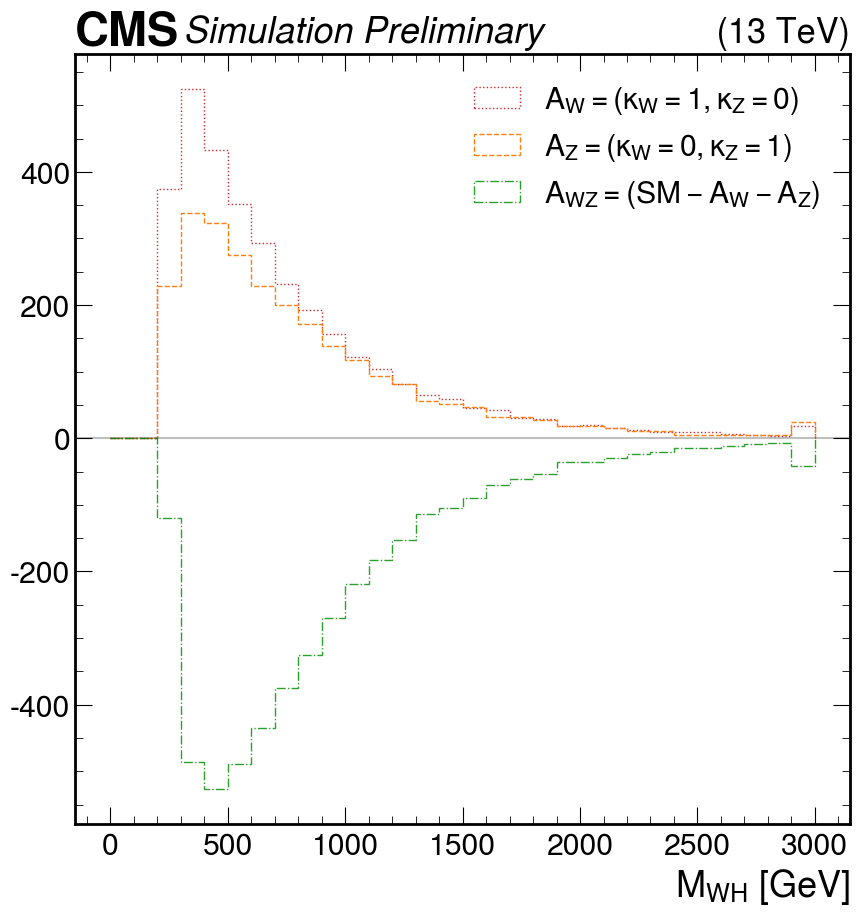

In [368]:
plot_breakdown("M_WH", np.linspace(0, 3000, 31))

Plotting ST for a selection of kW, kZ points...
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_mkW_mkZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_1p0kZ_kWpoints.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_mkW_mkZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_1p0kW_kZpoints.pdf
Plotting breakdown components alone...
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_breakdown_components.pdf
Plotting ST breakdown for all kW, kZ points...
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_breakdown_1p0kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_breakdown_m0p1kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_breakdown_0p1kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_breakdown_1p5kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html/lhe_plots/vbswh/lhe_ST_breakdown_m1p0kW_1p0kZ.pdf
Wrote /home/users/jguiang/public_html

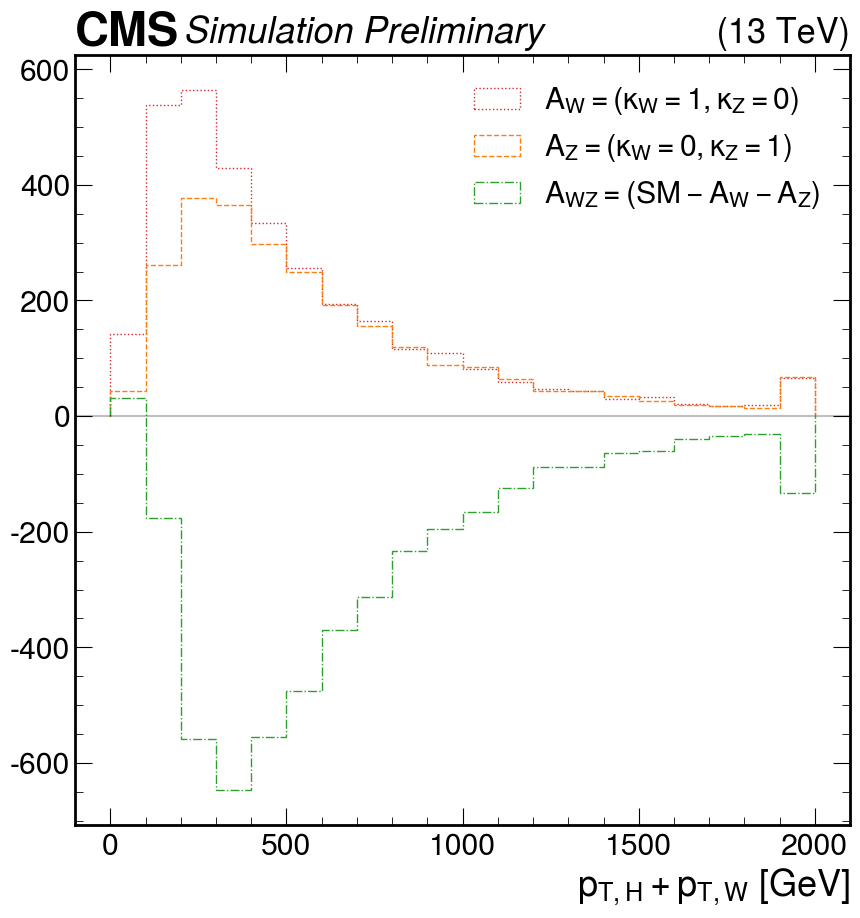

In [369]:
plot_breakdown("ST", np.linspace(0, 2000, 21))